#1. Preprocessing

## Required packages

In [2]:
    #!pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    #!pip install accelerate # for quantization model loading
    #!pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 91.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1

In [3]:
!pip install -U pip setuptools wheel
!pip install -U spacy

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 75.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 71.0.4
    Uninstalling setuptools-71.0.4:
      Successfully uninstalled setuptools-71.0.4
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


## Import and read PDF document

In [11]:
import os
import requests

# Get PDF document path
pdf_path = '/content/drive/MyDrive/1.Projects/RAG/O-RAN-WG4.CUS.0-v08.00.pdf'

# Download PDF
if not os.path.exists(pdf_path):
  print(f"File doesn't exist, downloading...")

  # Enter the URL of PDF
  url = 'https://specifications.o-ran.org/download?id=219'

  # The local file name to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if request is successful
  if response.status_code == 200:
    # Open file and save it
    with open(filename, 'wb') as file:
      file.write(response.content)
    print(f"The file has been downloaded and saved as {filename}")
  else:
    print(f'Failed to download file. Status code: {response.status_code}')

### Document text preprocessing


Through some experimentation, text formatter is needed to ignore headers and footers on every page.

In [12]:
import re

def text_formatter(text: str, next_page_text: str = None) -> str:
    """Flattens text by replacing new lines with spaces, stripping extra white spaces,
    and handling headers/footers more robustly."""
    # Remove new lines
    cleaned_text = text.replace("\n", " ").strip()

    # Define the unwanted header pattern (this appears at the top of each page)
    header_pattern = r'\s*\d+\s+O-RAN-WG4\.CUS\.0-v\d{2}\.\d{2}\s*'

    # Define the unwanted footer pattern (this appears at the bottom of each page)
    footer_pattern = (
        r'_{5,}\s+Copyright © \d{4} by the O-RAN ALLIANCE e\.V\.\s+'
        r'Your use is subject to the terms of the O-RAN Adopter License Agreement\s+'
        r'in the Annex ZZZ\.\s*'
    )

    # Remove the unwanted header pattern using regular expressions
    cleaned_text = re.sub(header_pattern, '', cleaned_text)

    # Remove the unwanted footer pattern using regular expressions
    cleaned_text = re.sub(footer_pattern, '', cleaned_text)

    # Further trim any additional trailing spaces that may remain
    cleaned_text = cleaned_text.strip()

    return cleaned_text





Also, the documents tend to cut off contents when going from the end of one page, to start of another. Therefore, we need to merge context between the end of one page and beginning of another.

In [13]:
def merge_pages_with_context(pages_and_texts: list) -> list:
    """Merge fragmented text from consecutive pages."""
    merged_texts = []
    for i, item in enumerate(pages_and_texts):
        current_text = item['text']

        if i < len(pages_and_texts) - 1:
            next_text = pages_and_texts[i + 1]['text']

            # Check if the current text ends with an incomplete sentence
            if not re.search(r'[.!?]$', current_text):
                # Merge with the start of the next page
                first_sentence_next_page = next_text.split(".")[0].strip()
                current_text += f" {first_sentence_next_page}"

        merged_texts.append({
            'page_number': item['page_number'],
            'text': current_text,
            'char_count': len(current_text),
            'word_count': len(current_text.split(" ")),
            'sentence_count': len(current_text.split(". ")),  # Sentence count using period
            'token_count': len(current_text) / 4  # Approximate token count
        })

    return merged_texts

In [14]:
#Import PDF reader library
import fitz
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm



# Read PDF
def read_pdf(pdf) -> list[dict]:
  """
  Opens and reads the PDF file page by page and collects statistics

  Returns:
  A list of dict containing page number, word count, sentence count, token count, and the actual text.

  """

  doc = fitz.open(pdf_path) #opens the PDF
  pages_dicts = []

  for page_number in range(len(doc)):
      page = doc[page_number]
      text = page.get_text()

      # Get next page's text if available for potential merging
      next_page_text = doc[page_number + 1].get_text() if page_number + 1 < len(doc) else None

      # Clean and format text
      formatted_text = text_formatter(text, next_page_text)

  for page_number, page in tqdm(enumerate(doc)):
      text = page.get_text()
      text = text_formatter(text)
      pages_dicts.append({
              'page_number': page_number,
              'text': text,
              'char_count': len(text),
              'word_count': len(text.split(" ")),
              'sentence_count': len(text.split(". ")), # Rough estimate of sentences
              'token_count': len(text)/4}) # 1 token = ~4 characters

  return pages_dicts

pdf = read_pdf(pdf_path)
pdf[:3]

0it [00:00, ?it/s]

[{'page_number': 0,
  'text': 'O-RAN-WG4.CUS.0-v08.00 Technical Specification   O-RAN Working Group 4 (Open Fronthaul Interfaces WG) Control, User and Synchronization Plane Specification  This is a re-published version of the attached final specification.  For this re-published version, the prior versions of the IPR Policy will apply, except that the previous  requirement for Adopters (as defined in the earlier IPR Policy) to agree to an O-RAN Adopter License  Agreement to access and use Final Specifications shall no longer apply or be required for these Final  Specifications after 1st July 2022. The copying or incorporation into any other work of part or all of the material available in this  specification in any form without the prior written permission of O-RAN ALLIANCE e.V.  is prohibited,  save that you may print or download extracts of the material on this site for your personal use, or copy  the material on this site for the purpose of sending to individual third parties for the

We need to preprocess the pages_and_texts object to merge any cut offs between end of page and to the next page.

In [15]:
pages_and_texts = merge_pages_with_context(pdf)
pages_and_texts[:3]

[{'page_number': 0,
  'text': 'O-RAN-WG4.CUS.0-v08.00 Technical Specification   O-RAN Working Group 4 (Open Fronthaul Interfaces WG) Control, User and Synchronization Plane Specification  This is a re-published version of the attached final specification.  For this re-published version, the prior versions of the IPR Policy will apply, except that the previous  requirement for Adopters (as defined in the earlier IPR Policy) to agree to an O-RAN Adopter License  Agreement to access and use Final Specifications shall no longer apply or be required for these Final  Specifications after 1st July 2022. The copying or incorporation into any other work of part or all of the material available in this  specification in any form without the prior written permission of O-RAN ALLIANCE e.V.  is prohibited,  save that you may print or download extracts of the material on this site for your personal use, or copy  the material on this site for the purpose of sending to individual third parties for the

## Explore document page statistics

In [16]:
import pandas as pd

pdf_df = pd.DataFrame(pages_and_texts)
pdf_df.head()

,page_number,text,char_count,word_count,sentence_count,token_count
0,0,O-RAN-WG4.CUS.0-v08.00 Technical Specification...,1169,198,4,292.25
1,1,O-RAN-WG4.CUS.0-v08.00 Technical Specification...,897,166,7,224.25
2,2,Revision history Date Revision Description ...,1373,230,10,343.25
3,3,Contents Revision history .....................,8001,460,52,2000.25
4,4,6 Security .....................................,8755,600,59,2188.75


In [17]:
# Statistics
pdf_df.describe().round()

,page_number,char_count,word_count,sentence_count,token_count
count,336.0,336.0,336.0,336.0,336.0
mean,168.0,2638.0,503.0,14.0,660.0
std,97.0,1236.0,206.0,10.0,309.0
min,0.0,158.0,31.0,1.0,40.0
25%,84.0,1893.0,378.0,7.0,473.0
50%,168.0,2606.0,502.0,14.0,652.0
75%,251.0,3271.0,630.0,21.0,818.0
max,335.0,8956.0,1278.0,60.0,2239.0


Average token count: 660 --> **We need to find a embedding model with context window > 660 tokens.**

Or better yet, we will split the texts into chunks

## Splitting Text into Chunks

We need to split into chunks because 630 tokens per page seem a little too much. We will break it down into 10 sentences per chunk.

In [18]:
from spacy.lang.en import English

nlp = English()

# Create a sentencizer pipeline
nlp.add_pipe('sentencizer')

# Use spacy to split into sentences

#Loop over each page to split sentences
for item in tqdm(pages_and_texts):
  doc = nlp(item['text'])
  sentences = [sent.text for sent in doc.sents]
  item['sentences'] = sentences # New column with list of sentences

  item['sentence_count_spacy'] = len(item['sentences'])  # New column with sentence count by Spacy




  0%|          | 0/336 [00:00<?, ?it/s]

In [19]:
import random
random.sample(pages_and_texts, 1)

[{'page_number': 73,
  'text': '•  𝑆𝐹5:  The start of SF5, SF6, SF7, SF8, or SF9  •  At 𝐷𝑅𝑆𝑡ℎ,1, O-DU sends DRS_v1 (i.e., to be transmitted within SFs 0-4)  •  At 𝐷𝑅𝑆𝑡ℎ,2, O-DU sends DRS_v2 (i.e., to be transmitted within SFs 5-9)  •  Notes:   1. LBT indication with failure outcome shall be sent for every sensing period.   7.3.4.3.3  Congestion Window Information Transmission  •  O-DU should send information regarding a congestion window adjustment to O-RU  •  HARQ feedback information for the reference subframe and number of TB are included  •  O-RU should adjust its managed congestion window value and notify to O-DU the packet reception status  •  O-RU should adjust its congestion window value based on received information  •  O-RU should immediately send a success LBT_CWCONFIG_RSP to the O-DU when the message is  successfully received. If not, O-RU should send a fail LBT_CWCONFIG_RSP.    7.3.5  Symbol Numbering and Duration  For the NR case, data symbol numbering in a slot shall be 

In [20]:
spacy_df = pd.DataFrame(pages_and_texts)
spacy_df.head(10)

,page_number,text,char_count,word_count,sentence_count,token_count,sentences,sentence_count_spacy
0,0,O-RAN-WG4.CUS.0-v08.00 Technical Specification...,1169,198,4,292.25,[O-RAN-WG4.CUS.0-v08.00 Technical Specificatio...,3
1,1,O-RAN-WG4.CUS.0-v08.00 Technical Specification...,897,166,7,224.25,[O-RAN-WG4.CUS.0-v08.00 Technical Specificatio...,3
2,2,Revision history Date Revision Description ...,1373,230,10,343.25,[Revision history Date Revision Description...,10
3,3,Contents Revision history .....................,8001,460,52,2000.25,[Contents Revision history ....................,1
4,4,6 Security .....................................,8755,600,59,2188.75,[6 Security ....................................,1
5,5,11 S-Plane Protocol ............................,8956,585,60,2239.00,[11 S-Plane Protocol ...........................,1
6,6,A.3.2 -Law Decompression Algorithm ............,7700,590,52,1925.00,[A.3.2 -Law Decompression Algorithm ...........,1
7,7,M.3 Selective transmission and reception with...,2197,137,14,549.25,[M.3 Selective transmission and reception wit...,1
8,8,Foreword This Technical Specification (TS) ha...,1208,200,9,302.00,[Foreword This Technical Specification (TS) h...,8
9,9,1 Scope The present document specifies the c...,3228,513,25,807.00,[1 Scope The present document specifies the ...,22


In [21]:
spacy_df.iloc[5,1]

'11  S-Plane Protocol .............................................................................................................................  188  11.1  General ....................................................................................................................................................  188  11.1.1  Overview  ............................................................................................................................................  188  11.2  Synchronization Baseline .........................................................................................................................  188  11.2.1  List of Reference Documents ..............................................................................................................  188  11.2.2  Clock Model and Synchronization Topology  .......................................................................................  188  11.2.3  Clock Synchronization  .........................

As we can see above, *sentence_count* and **sentence_count_spacy** differs quite a bit.

 *sentence_count* used the delimiter of ". "
  This is an issue upon inspecting the actual text of one of the pages, There are many "." in the page as it is the table of contents, which explains why *sentence_count* for some pages results in 60 sentence. While **sentence_count_spacy** counted only 1.

  **Therefore, we will be using spacy for sentence counting going forward**

In [22]:
# A function for grouping the sentence splits into groups of n sentences

def chunk_sentences(sentences: list[str], chunk_size):
  chunks = []
  for i in range(0, len(sentences), chunk_size):
    chunk = sentences[i:i+chunk_size]
    chunks.append(chunk)
  return chunks


# Loop through the pages
for item in tqdm(pages_and_texts):
  item['chunks'] = chunk_sentences(item['sentences'], 3)

  0%|          | 0/336 [00:00<?, ?it/s]

In [23]:
random.sample(pages_and_texts, 1)

[{'page_number': 257,
  'text': '-  compShift, 4-bits, (LSB)  •  IQ samples, total bits = 12x 2x compBitWidth  -  1st sample I, compBitWidth-bits  -  1st sample Q, compBitWidth-bits  -  2nd sample I, compBitWidth-bits  -  2nd sample Q, compBitWidth-bits  -  …  -  12th sample I, compBitWidth-bits  -  12th sample Q, compBitWidth-bits  A.4  Beamspace Compression Type I and Type II  There are two types of beamspace compression methods, i.e., beamspace compression Type I and beamspace  compression Type II. The beamspace compression methods are specific to beamforming weights and is not suitable for  user or control IQ data.  Hence these compression methods will only be used as part of the bfwCompMeth in the C- Plane. Table A.4.1 lists the basic characteristics of the two methods.    Table A.4.1 : Beamspace compression Type I and II    Transformation  IQ value compression  Beamspace compression Type I  Only use 1D-DFT-based  transformation   Block scaling  Beamspace compression Type II  Line

Now we want to make each chunk a seperate row in the dataframe.

We will join the sentences together into one single paragraph.

In [24]:
# Loop through sentences in each chunk to join them into one paragraph

for item in tqdm(pages_and_texts):
  item['joined_chunks'] = [" ".join(chunk) for chunk in item['chunks']]


# Create a new dict of chunk texts

chunks_list = []

for item in pages_and_texts:
  for chunk in item['joined_chunks']:
    chunks_list.append({
        'page_number': item['page_number'],
        'chunk': chunk,
        'chunk_char_count': len(chunk),
        'chunk_word_count': len(chunk.split(" ")),
        'chunk_sentence_count': len(list(nlp(chunk).sents)), # Use spacy for sentence count
        'chunk_token_count': len(chunk)/4 # 4 token = 1 word
    })




  0%|          | 0/336 [00:00<?, ?it/s]

In [25]:
# Create a new df and inspect

chunks_df = pd.DataFrame(chunks_list)
chunks_df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_sentence_count,chunk_token_count
count,1536.00,1536.00,1536.00,1536.00,1536.00
mean,157.88,576.31,110.01,2.77,144.08
std,90.65,583.80,112.62,0.59,145.95
min,0.00,22.00,5.00,1.00,5.50
25%,84.75,319.75,56.00,3.00,79.94
50%,154.00,446.50,79.00,3.00,111.62
75%,227.00,662.00,121.00,3.00,165.50
max,335.00,8956.00,1000.00,3.00,2239.00


Looks like some chunks have a low token count. This might be some boiler plate texts.

*Let's inspect the contents of chunk_token_count < 30.*

In [26]:
small_token_chunks = chunks_df[chunks_df['chunk_token_count'] < 30]

for index, row in small_token_chunks.iterrows():
  print(f"Token Size: {row['chunk_token_count']}")
  print(f"Page Number: {row['page_number']}")
  print(f"Chunk: {row['chunk']}")
  print("-" * 80)  # Separator line for readability


Token Size: 29.5
Page Number: 16
Chunk: Precoding in  radio is not supported.  O-RU Category A  Precoding O-RAN Radio  Unit. Precoding in radio is  supported.
--------------------------------------------------------------------------------
Token Size: 27.75
Page Number: 18
Chunk:  The option of including some PHY functionality in a radio unit was not included in [13].  O-RAN FH  O-RAN FH 4
--------------------------------------------------------------------------------
Token Size: 16.75
Page Number: 23
Chunk:  It does not define the exact timing of transmission from the O-DU.
--------------------------------------------------------------------------------
Token Size: 26.0
Page Number: 24
Chunk:  (Note that it is possible for Tcp_adv_dl to be set to 0, but the O-RAN delay model does not assume this
--------------------------------------------------------------------------------
Token Size: 21.0
Page Number: 27
Chunk:     Figure 4.3.2-3 : Timing relations for PRACH (Example 1: PRACH Form

Looks like these are important contents. Let's keep it this way.

## Embedding text chunks

How should we pick the embedding models?


*   Maximum sequence size of model compared with the token count of each chunk
*   Contents of each chunk may be truncated if maximum sequence size of the model is less than the chunk token count.

So we need to observe the distribution of the chunk token size and make sure all of them are within the context window of the embedding models



<Axes: >

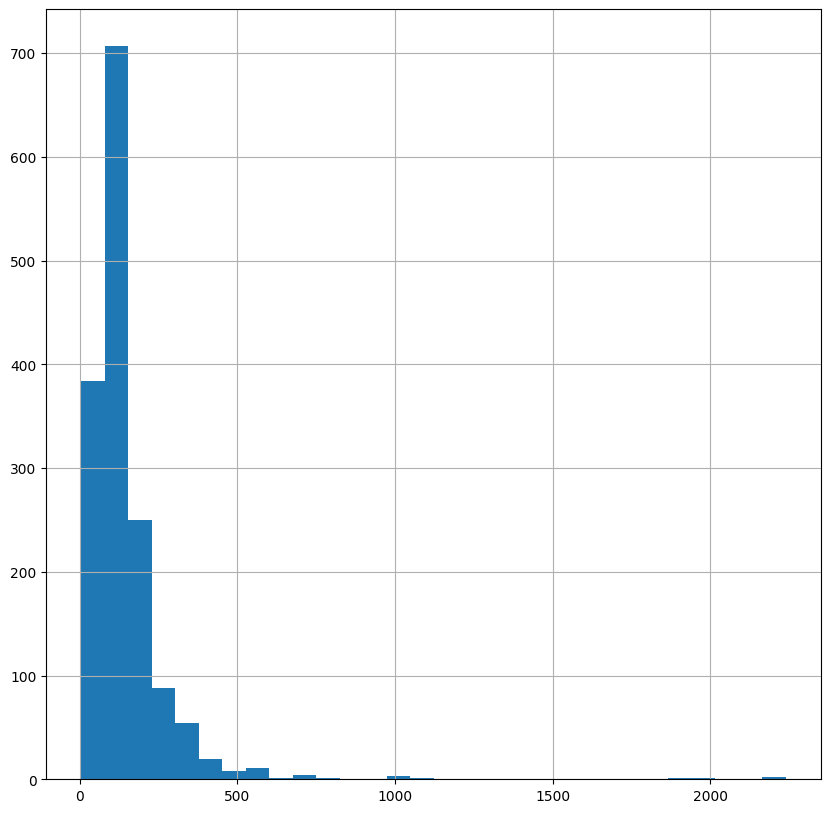

In [27]:
chunks_df['chunk_token_count'].hist(figsize=(10,10), bins=30)

Now the above histogram took some trial and errors. I started with 10 sentences per chunk, but soon realized that there are many chunks with above 500 token size. So I gradually reduced it and reached 3 sentences per chunk, at the cost of extra compute.

Now we can use the best performing sentence transformer from hugging face which has a maximum sequence length of 384

In [42]:
%%time
# Import embedding model from sentence transformer

from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

#Send model to GPU
embedding_model.to('cuda')

# Convert chunks into a single list
chunks_list = chunks_df['chunk'].tolist()

# Embed the chunks
embedded_chunks = embedding_model.encode(chunks_list, batch_size=32, convert_to_tensor=True)

embedded_chunks


CPU times: user 11.9 s, sys: 303 ms, total: 12.2 s
Wall time: 11.4 s


tensor([[-0.0426, -0.0620, -0.0016,  ..., -0.0320, -0.0630,  0.0114],
        [-0.0627, -0.0805,  0.0020,  ..., -0.0487, -0.0352,  0.0373],
        [-0.0245, -0.0573, -0.0195,  ..., -0.0196, -0.0617, -0.0527],
        ...,
        [ 0.0504, -0.0647,  0.0240,  ..., -0.0054, -0.0128,  0.0350],
        [ 0.0380,  0.0262,  0.0082,  ...,  0.0221, -0.0870, -0.0149],
        [ 0.0423,  0.0650,  0.0260,  ...,  0.0400, -0.0412,  0.0432]],
       device='cuda:0')

### Save embeddings to file

In [43]:
embedded_chunks_df = pd.DataFrame(embedded_chunks.cpu())
embedded_chunks_df.to_csv('/content/drive/MyDrive/1.Projects/RAG/embedded_chunks.csv', index=False)


# 2. Retrieval

Now that we have the embeddings of the documents, we can just start the notebook from here. Start by loading the embeddings.

In [70]:
# Load embeddings

import pandas as pd
import torch

embedded_chunks_df = pd.read_csv('/content/drive/MyDrive/1.Projects/RAG/embedded_chunks.csv')

# Convert it back to tensor float32 from string
embedded_chunks = torch.tensor(embedded_chunks_df.values)

# Convert to float32
embedded_chunks = embedded_chunks.float()

# Move to GPU
embedded_chunks = embedded_chunks.to('cuda')

print(embedded_chunks.dtype)
print(embedded_chunks.shape)


torch.float32
torch.Size([1536, 768])


Make another instnace of model so we can just load and continue the project from here on since the preprocessing stage cells are no longer needed

In [49]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embedding_model.to('cuda')


SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

Let's begin semantic search!
High level tasks:
1. Embed the query
2. Do a similarty search between embedded query and document

In [71]:
query = "What is O-RAN?"
print(f"Query: {query}")

# Embed the query
embedded_query = embedding_model.encode(query, convert_to_tensor=True)

print(embedded_chunks.dtype)
print(embedded_chunks.shape)


Query: What is O-RAN?
torch.float32
torch.Size([1536, 768])


Now we will perform a similarity search between query and document embeddings.

For our case, we can use cosine similarity, since we don't have a large document.

If in case we do have a large document embeddings, we would need to store them in a vector database and perform a nearest neighbour search to be more computational efficient.

In [75]:
import torch

def get_top_k_similarities(query_embedding, document_embeddings, k=5):
    """
    Compute cosine similarity between the query embedding and all document embeddings,
    then retrieve the top k most similar documents.

    Args:
    query_embedding: A 1D tensor representing the query embedding.
    document_embeddings: A 2D tensor representing the document embeddings.
    k: The number of top results to retrieve.

    Returns:
    The top k cosine similarities and their corresponding indices.
    """
    # Ensure both tensors are of the same type (Float)
    query_embedding = query_embedding.float()
    document_embeddings = document_embeddings.float()

    # Normalize the embeddings
    query_embedding = query_embedding / torch.norm(query_embedding)
    document_embeddings = document_embeddings / torch.norm(document_embeddings, dim=1, keepdim=True)

    # Compute cosine similarity
    cosine_similarities = torch.matmul(document_embeddings, query_embedding)

    # Get the top k results
    top_k_similarities, top_k_indices = torch.topk(cosine_similarities, k)

    return top_k_similarities, top_k_indices


In [76]:
# Get top 5 most similar documents
top_k_similarities, top_k_indices = get_top_k_similarities(embedded_query, document_embeddings, k=5)

# Print results
print("Top k cosine similarities:", top_k_similarities)
print("Indices of top k similar documents:", top_k_indices)


Top k cosine similarities: tensor([0.6067, 0.5809, 0.5367, 0.5240, 0.5180], device='cuda:0')
Indices of top k similar documents: tensor([1528, 1030,  954, 1520, 1522], device='cuda:0')
